In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from qspectro2d.core.laser_system.laser_fcts import e_pulses, epsilon_pulses
from qspectro2d.spectroscopy import compute_spectra
from qspectro2d.visualization import plot_example_evo, plot_2d_el_field, plot_all_pulse_components, plot_pulse_envelopes, plot_e_pulses
from qspectro2d.spectroscopy.e_field_1d import compute_polarization_over_window, compute_evolution, sim_with_only_pulses, phase_cycle_component
from qspectro2d.utils.rwa_utils import get_expect_vals_with_RWA
from qspectro2d.config import create_base_sim_oqs

from plotstyle import init_style, COLORS, LINE_STYLES
init_style()

from pathlib import Path
custom_dir = Path("test_Spectroscopy")
custom_dir.mkdir(exist_ok=True)

In [2]:
# Build base simulation (applies CLI overrides inside)
from pathlib import Path
NOTEBOOK_DIR = Path.cwd()
for _parent in NOTEBOOK_DIR.parents:
    if (_parent / ".git").is_dir():
        PROJECT_ROOT = _parent
        break
SCRIPTS_DIR = (PROJECT_ROOT / "scripts").resolve()
config_path = SCRIPTS_DIR / "simulation_configs" / "_monomer.yaml"
sim_oqs, time_cut = create_base_sim_oqs(config_path)

🔧 Configured to use max_workers=8 for parallel tasks.
🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
=== SOLVER DIAGNOSTICS ===
Solver: ME
Time range: t0=-1330.000, t_max=600.000, dt=2.000000
Number of time points: 966
RWA enabled: True
=== SYSTEM DIAGNOSTICS ===
Initial state type, shape, is hermitian, trace: <class 'qutip.core.qobj.Qobj'>, (2, 2), True, 1.000000
Initial eigenvalues range: [0.000000, 1.000000]
Initial min eigenvalue: 0.0000000000
Total Hamiltonian dims: [[2], [2]]
Total Hamiltonian type: <class 'qutip.core.cy.qobjevo.QobjEvo'>
Number of decay channels: 2
Applying RWA phase factors: n_atoms=1, omega_laser=3.0139183281479043 [fs^-1]
=== STATE-BY-STATE ANALYSIS ===
✅ Checks passed. DM remains Hermitian and positive.
Final state trace: 1.000000
Final state min eigenvalue: 0.0032562569
############################################################
✅ Solver validation worked: Evolution becomes unphysical at (inf × t_max)


In [3]:
"""from qutip import mesolve, brmesolve, expect, basis
ode_solver = sim_oqs.simulation_config.ode_solver
sim_i = sim_with_only_pulses(sim_oqs, [1])
print(sim_i.laser)

ode_solver = sim_oqs.simulation_config.ode_solver
if ode_solver == "BR":
    # Optional Bloch-Redfield secular cutoff passthrough TODO add to options
    # sec_cutoff = options.get("sec_cutoff", None)
    res = brmesolve(
        H=sim_i.evo_obj,
        psi0=sim_i.system.psi_ini,
        tlist=sim_i.times_local,
    )
else:
    res = mesolve(
        H=sim_i.evo_obj,
        rho0=sim_i.system.psi_ini,
        tlist=sim_i.times_local,
    )

det_states = res.states
# Times for plotting/expectation values
times = res.times
rwa_sl = sim_i.simulation_config.rwa_sl

# Compute expectation values; pass dipole in the same basis as evolution (eigenbasis)
dipole_op_eig = sim_i.system.to_eigenbasis(sim_i.system.dipole_op)
expectation_values = get_expect_vals_with_RWA(
    det_states,
    times,
    sim_i.system.n_atoms,
    sim_i.observable_ops,
    sim_i.laser.carrier_freq_fs,
    rwa_sl=rwa_sl,
    dipole_op=dipole_op_eig,
)

fig, axes = plt.subplots(6, 1, figsize=(15, 10))
fig_evo = plot_example_evo(
    times,
    expectation_values,
    sim_i.laser,
    rwa_sl=rwa_sl,
    observable_strs=sim_i.observable_strs,
    ax=axes
)
norms_all = np.array([sim_oqs.H_int_sl(t).norm() for t in times])

axes[-1].plot(times, norms_all)
axes[-1].set_ylabel(r"$\|H_{int}(t)\|$")"""

'from qutip import mesolve, brmesolve, expect, basis\node_solver = sim_oqs.simulation_config.ode_solver\nsim_i = sim_with_only_pulses(sim_oqs, [1])\nprint(sim_i.laser)\n\node_solver = sim_oqs.simulation_config.ode_solver\nif ode_solver == "BR":\n    # Optional Bloch-Redfield secular cutoff passthrough TODO add to options\n    # sec_cutoff = options.get("sec_cutoff", None)\n    res = brmesolve(\n        H=sim_i.evo_obj,\n        psi0=sim_i.system.psi_ini,\n        tlist=sim_i.times_local,\n    )\nelse:\n    res = mesolve(\n        H=sim_i.evo_obj,\n        rho0=sim_i.system.psi_ini,\n        tlist=sim_i.times_local,\n    )\n\ndet_states = res.states\n# Times for plotting/expectation values\ntimes = res.times\nrwa_sl = sim_i.simulation_config.rwa_sl\n\n# Compute expectation values; pass dipole in the same basis as evolution (eigenbasis)\ndipole_op_eig = sim_i.system.to_eigenbasis(sim_i.system.dipole_op)\nexpectation_values = get_expect_vals_with_RWA(\n    det_states,\n    times,\n    sim

LaserPulseSequence Summary
--------------------------------------------------------------------------------
Pulse  0: t = -1300.00 fs | E₀ = 5.000e-02 | FWHM = 15.0 fs | ω = 16000.00 cm^-1 | ϕ =  0.000 rad | type = gaussian
Pulse  1: t = -1000.00 fs | E₀ = 5.000e-02 | FWHM = 15.0 fs | ω = 16000.00 cm^-1 | ϕ =  0.000 rad | type = gaussian
Pulse  2: t =   0.00 fs | E₀ = 5.000e-03 | FWHM = 15.0 fs | ω = 16000.00 cm^-1 | ϕ =  0.000 rad | type = gaussian


Text(152.77350523238593, 0.5, '$\\|H_{int}(t)\\|$')

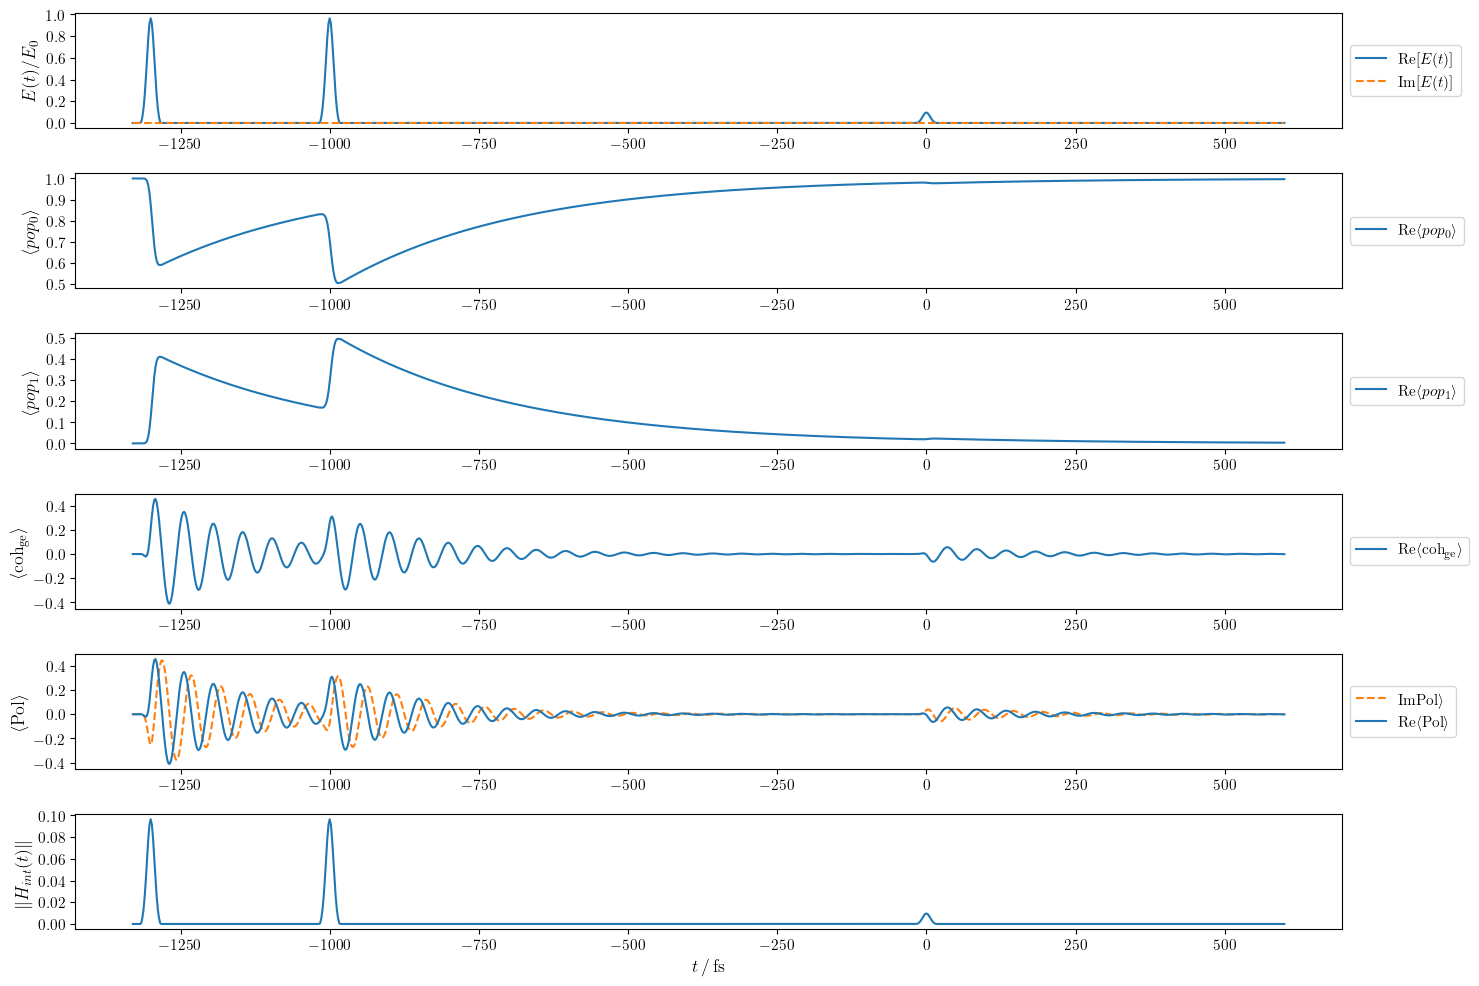

In [4]:
# Build an explicit copy (same pulses in this case)
sim_i = sim_with_only_pulses(sim_oqs, [0, 1, 2])
print(sim_i.laser)

res = compute_evolution(sim_i, store_states=True)
det_states = res.states
# Times for plotting/expectation values
times = res.times
rwa_sl = sim_i.simulation_config.rwa_sl

# Compute expectation values; pass dipole in the same basis as evolution (eigenbasis)
dipole_op_eig = sim_i.system.to_eigenbasis(sim_i.system.dipole_op)
expectation_values = get_expect_vals_with_RWA(
    det_states,
    times,
    sim_i.system.n_atoms,
    sim_i.observable_ops,
    sim_i.laser.carrier_freq_fs,
    rwa_sl=rwa_sl,
    dipole_op=dipole_op_eig,
)
# for monomer 2 levels  -> 6
# for dimer: monomer 4 levels  -> 10
# ...
fig, axes = plt.subplots(6, 1, figsize=(15, 10))
fig_evo = plot_example_evo(
    times,
    expectation_values,
    sim_i.laser,
    rwa_sl=rwa_sl,
    observable_strs=sim_i.observable_strs,
    ax=axes
)
norms_all = np.array([sim_i.H_int_sl(t).norm() for t in times])

axes[-1].plot(times, norms_all)
axes[-1].set_ylabel(r"$\|H_{int}(t)\|$")

# Workflow: `parallel_compute_1d_e_comps`

Super-short stepped visualization added below:
1. Inspect and plot laser pulses (envelope, RWA field, full field).
2. Run several evolutions with different active pulse subsets / modified parameters.
3. Plot expectation values + polarization for multiple detection sub-windows.
4. Build raw phase grid `P_{phi1,phi2}(t)` and extract a phase-cycled component.
5. (Mini 2D) Sweep a few coherence delays `t_coh` to assemble a tiny 2D block and phase-cycle each slice.

Each subsequent cell implements one step.


In [5]:
# Helper functions: polarization + phase-cycling pieces
def build_phase_grid(sim, phases):
    P_grid = []
    t_actual = None
    for phi1 in phases:
        row = []
        for phi2 in phases:
            sim_w = deepcopy(sim)
            sim_w.laser.pulse_phases = [phi1, phi2]
            t_actual, P_total = compute_polarization_over_window(sim_w, sim_w.t_det)
            # Linear signals: only pulse i active
            P_linear_sum = np.zeros_like(P_total, dtype=np.complex128)
            for i in range(len(sim_w.laser.pulses)):
                sim_i = sim_with_only_pulses(sim_w, [i])
                _, P_i = compute_polarization_over_window(sim_i, t_actual)
                P_linear_sum += P_i

            P_phi = P_total - P_linear_sum
            row.append(P_phi)
        P_grid.append(row)
    return t_actual, np.array(P_grid)  # shape (n,n,t)
print('Helpers ready.')

Helpers ready.


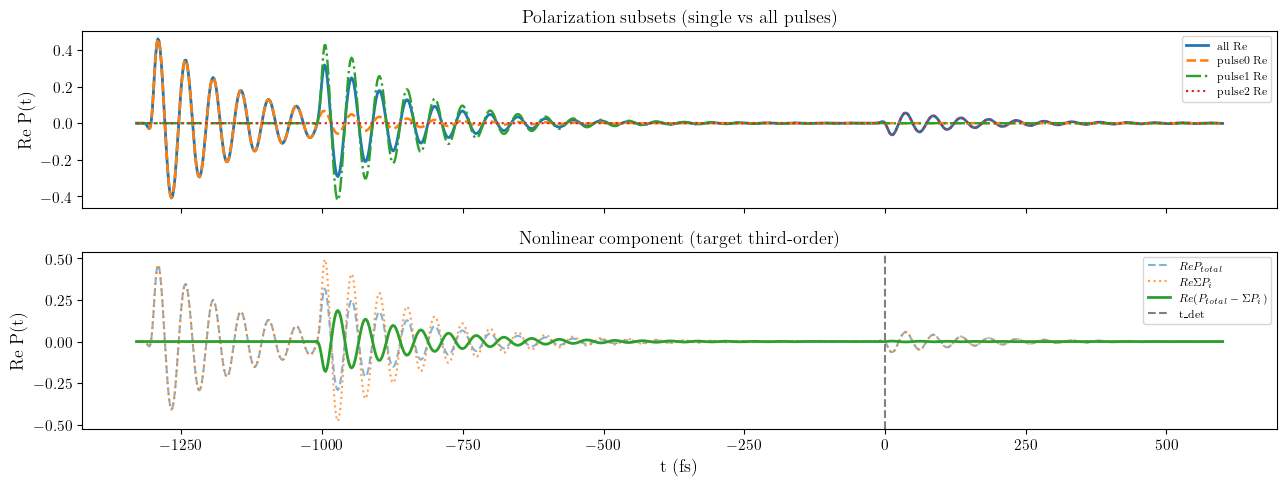

In [6]:
# 2. Evolution subsets: all pulses vs single pulse vs modified amplitude
subset_specs = {
    'all': list(range(len(sim_oqs.laser.pulses))),
}
# Add individual pulses
for i in range(len(sim_oqs.laser.pulses)):
    subset_specs[f'pulse{i}'] = [i]

pol_datas = {}
base_window = sim_oqs.times_local  # detection / plotting window (assumed uniform grid)

for label, idxs in subset_specs.items():
    sim_sub = sim_with_only_pulses(sim_oqs, idxs) if label != 'all' else sim_oqs
    t_actual, P = compute_polarization_over_window(sim_sub, base_window)
    pol_datas[label] = P

# Build nonlinear component: P_total - Σ_i P_i
P_total = pol_datas['all']
linear_sum = np.zeros_like(P_total, dtype=complex)
for i in range(len(sim_oqs.laser.pulses)):
    linear_sum += pol_datas[f'pulse{i}']
pol_nonlinear = P_total - linear_sum  # store for later reuse if needed

# Plotting: two subplots
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(13,5), sharex=True)
ax1, ax2 = axes

# Subplot 1: original subset comparison (real part)
for idx, (k, v) in enumerate(pol_datas.items()):
    ax1.plot(t_actual, np.real(v), color=COLORS[idx % len(COLORS)], linewidth=2-0.15*idx, label=f'{k} Re')
ax1.set_ylabel('Re P(t)')
ax1.set_title('Polarization subsets (single vs all pulses)')
ax1.legend(loc='best', fontsize=8)

# Subplot 2: nonlinear component extraction
ax2.plot(t_actual, np.real(P_total), label='$Re P_{total}$', linestyle='--', color=COLORS[0], alpha=0.55)
ax2.plot(t_actual, np.real(linear_sum), label='$Re \Sigma P_i$', linestyle=':', color=COLORS[1], alpha=0.75)
ax2.plot(t_actual, np.real(pol_nonlinear), label='$Re (P_{total} - \Sigma P_i)$', color=COLORS[2], linewidth=2.0)
# make a vertical line at t_det[0]
ax2.axvline(x=sim_oqs.t_det[0], color='gray', linestyle='--', label='t_det')
ax2.set_ylabel('Re P(t)')
ax2.set_xlabel('t (fs)')
ax2.set_title('Nonlinear component (target third-order)')
ax2.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

In [7]:
# 4. Phase grid raw vs extracted component (expanded visualization)
from qspectro2d.config.default_simulation_params import PHASE_CYCLING_PHASES, DETECTION_PHASE
phases = PHASE_CYCLING_PHASES[:4]  # small subset for speed

# Build raw grid (n_phi, n_phi, n_t)
t_actual, P_grid = build_phase_grid(sim_oqs, phases)
comp = phase_cycle_component(phases, P_grid, lmn=(1,-1,1), phi_det=DETECTION_PHASE)

# Select several (phi1, phi2) pairs to display (indices into phases)
# Always include (0,0) and (last,last); add a few interior/off-diagonal examples.
max_idx = len(phases) - 1
pairs_to_show = [(0,0)]
if max_idx >= 1:
    pairs_to_show.append((0, max_idx))  # corner
if max_idx >= 2:
    pairs_to_show.append((1, 2))        # interior
if max_idx >= 3:
    pairs_to_show.append((2, 1))        # off-diagonal reversed
pairs_to_show.append((max_idx, max_idx))

# Prepare figure: raw traces + component at bottom
n_raw = len(pairs_to_show)
import matplotlib.pyplot as plt
fig, axes = plt.subplots(n_raw + 3, 1, figsize=(10, 2.0*(n_raw+1)), sharex=True)

# Color / style cycling
from itertools import cycle
line_styles = cycle(['solid','dashed','dashdot','dotted'])

for ax, (i,j) in zip(axes[:-3], pairs_to_show):
    trace = P_grid[i,j]
    ls = next(line_styles)
    color_idx = (i * len(phases) + j) % len(COLORS)
    ax.plot(t_actual, np.real(trace), color=COLORS[color_idx], linestyle=ls, linewidth=1.6,
            label=fr"Re $P_{{\phi_1={phases[i]:.2f},\;\phi_2={phases[j]:.2f}}}(t)$")
    ax.plot(t_actual, np.imag(trace), color=COLORS[(color_idx+1)%len(COLORS)], linestyle=':', linewidth=1.2,
            label=fr"Im $P_{{\phi_1={phases[i]:.2f},\;\phi_2={phases[j]:.2f}}}(t)$")
    ax.set_ylabel(r"$P$")
    ax.legend(fontsize=8, loc='upper right')

# Component subplot
axc = axes[-3]
axc.plot(t_actual, np.real(comp), color=COLORS[0], linewidth=2.0, label=r"Re $P_{1,-1,1}(t)$")
axc.plot(t_actual, np.imag(comp), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im $P_{1,-1,1}(t)$")
axc.set_ylabel(r"$P_{1,-1,1}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('Rephasing')
axc.legend(fontsize=9, loc='upper right')

# Extra: show another component (e.g. (-1,1,1)) for comparison
comp2 = phase_cycle_component(phases, P_grid, lmn=(-1,1,1), phi_det=DETECTION_PHASE)
axc = axes[-2]
axc.plot(t_actual, np.real(comp2), color=COLORS[0], linewidth=2.0, label=r"Re $P_{-1,1,1}(t)$")
axc.plot(t_actual, np.imag(comp2), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im $P_{-1,1,1}(t)$")
axc.set_ylabel(r"$P_{-1,1,1}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('NonRephasing')
axc.legend(fontsize=9, loc='upper right')

# Extra: show another component (e.g. (0, 0, 0)) for comparison
comp3 = phase_cycle_component(phases, P_grid, lmn=(0, 0, 0), phi_det=DETECTION_PHASE)
axc = axes[-1]
axc.plot(t_actual, np.real(comp3), color=COLORS[0], linewidth=2.0, label=r"Re $P_{0,0,0}(t)$")
axc.plot(t_actual, np.imag(comp3), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"Im $P_{0,0,0}(t)$")
axc.set_ylabel(r"$P_{0,0,0}$")
axc.set_xlabel('t_det (fs)')
axc.set_title('Average')
axc.legend(fontsize=9, loc='upper right')
plt.tight_layout()
plt.show()

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

In [ ]:
# 5. Mini 2D demo: scan a few coherence pulse_delays (t_coh values) and phase-cycle each 1D slice
# NOTE: This is a lightweight illustrative sweep, not a full 2D simulation pipeline.
t_det = sim_oqs.t_det
half_time = 0.8 * t_det[-1]              # half of the last detection time
mask = t_det >= half_time                # boolean mask
mini_t_coh = t_det[mask][::20]            # apply mask, then take every 2th

components_2d_R = []
components_2d_NonRephasing = []
pulse_times_matrix = []  # store resulting peak times for diagnostics

for tcoh in mini_t_coh:
    sim_c = deepcopy(sim_oqs)
    # Adjust ONLY the first inter-pulse delay using new `pulse_delays` property.
    sim_c.update_delays(t_coh=tcoh)
    # Recompute polarization phase grid for this t_coh
    t_actual2d, P_grid2d = build_phase_grid(sim_c, phases)
    comp2d_R = phase_cycle_component(phases, P_grid2d, lmn=(-1,1, 1), phi_det=DETECTION_PHASE)
    components_2d_R.append(comp2d_R)
    comp2d_NonRephasing = phase_cycle_component(phases, P_grid2d, lmn=(1,-1,1), phi_det=DETECTION_PHASE)
    # components_2d_NonRephasing.append(comp2d_NonRephasing)

# Diagnostics: show first few rows of resulting pulse peak times
print('Pulse peak times per t_coh (rows):')
print(pulse_times_matrix)

components_2d_R = np.array(components_2d_R)  # shape (n_t_coh, n_t_det)
# components_2d_NonRephasing = np.array(components_2d_NonRephasing)  # shape (n_t_coh, n_t_det)
pulse_times_matrix = np.array(pulse_times_matrix)

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

Text(0.5, 1.0, 'Absolute Value of 2D Field in Time Domain')

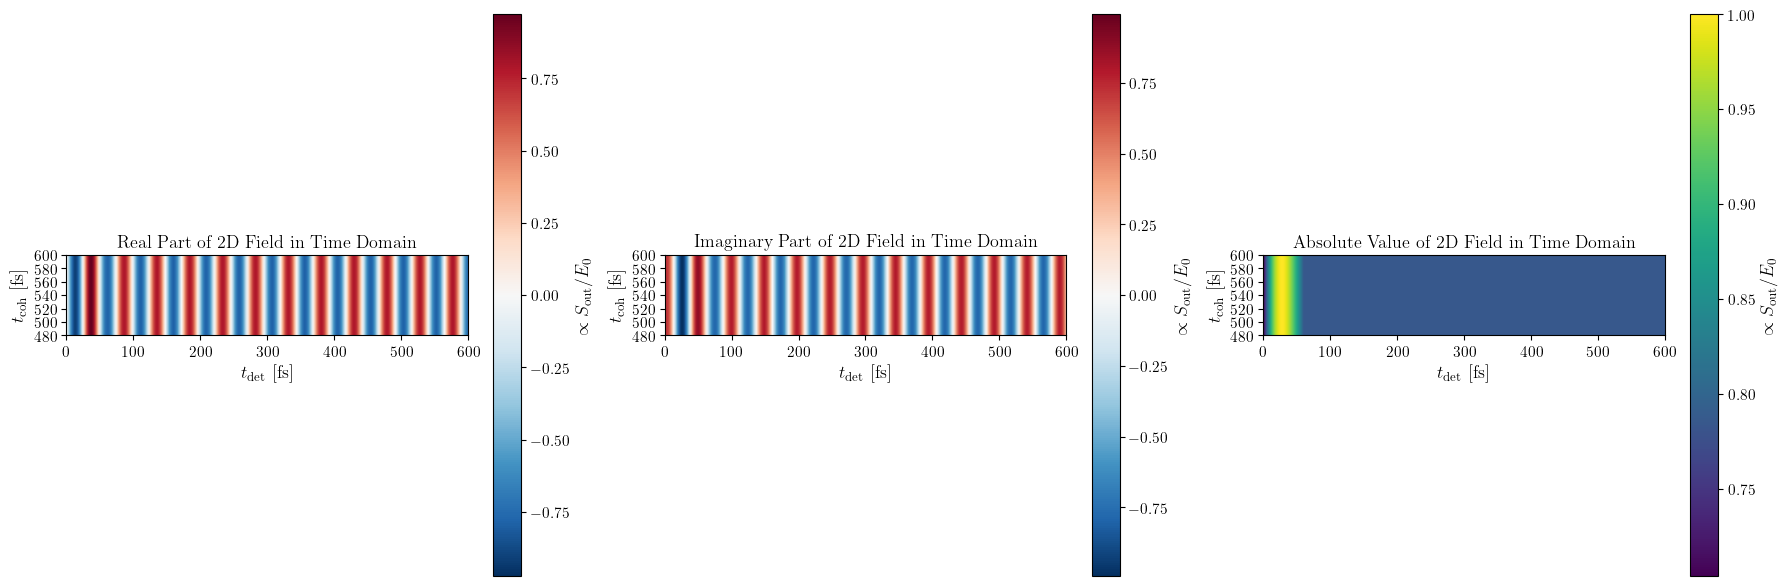

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_2d_el_field(
    ax=axes[0],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="real",
)
axes[0].set_title(r"Real Part of 2D Field in Time Domain")

# Plot imaginary component
plot_2d_el_field(
    ax=axes[1],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="img",
)
axes[1].set_title(r"Imaginary Part of 2D Field in Time Domain")

# Plot absolute component
plot_2d_el_field(
    ax=axes[2],
    axis_det=t_actual2d,
    axis_coh=mini_t_coh,
    data=components_2d_R,
    domain="time",
    component="abs",
)
axes[2].set_title(r"Absolute Value of 2D Field in Time Domain")

Text(0.5, 1.0, 'Absolute Value of 2D Field in Frequency Domain')

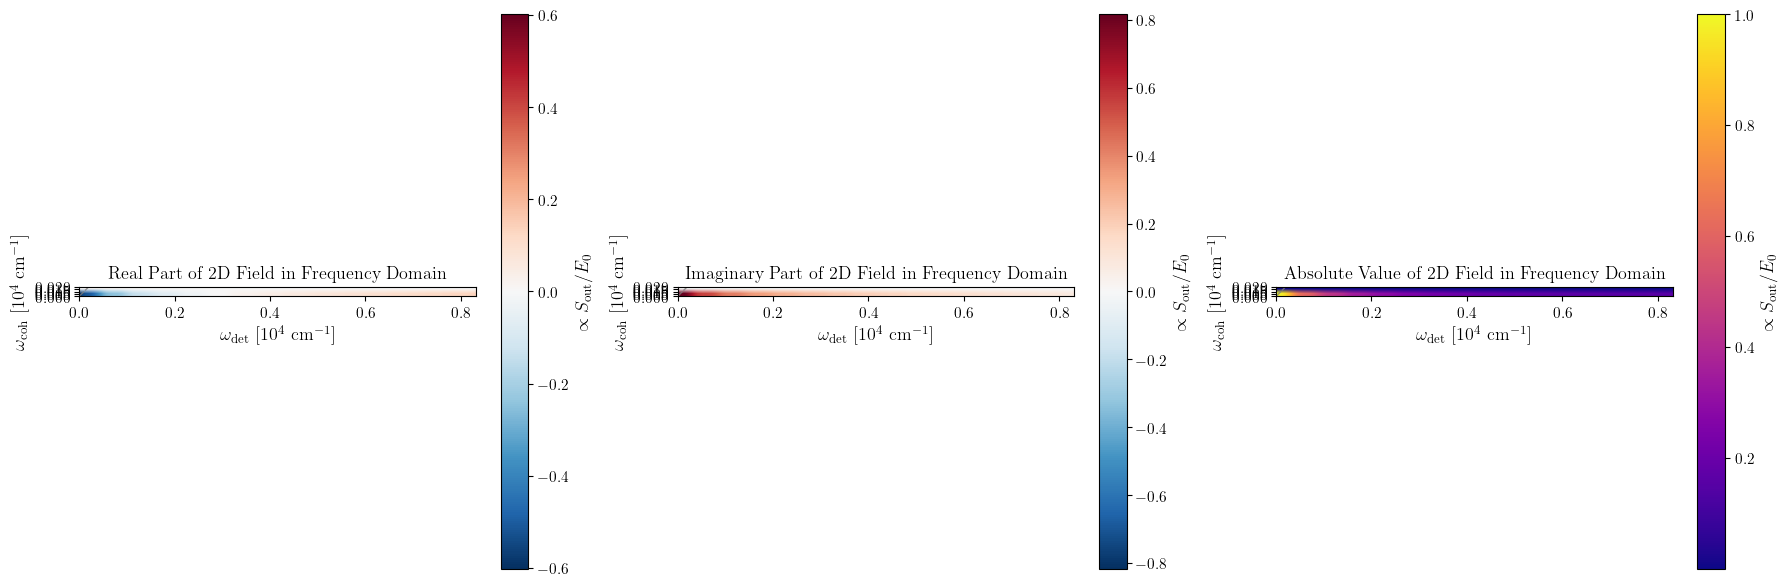

In [ ]:
nu_coh, nu_det, S_2d_R_list, labels_R = compute_spectra(
    datas=[components_2d_R],
    signal_types=["rephasing"],
    t_det=t_actual2d,
    t_coh=mini_t_coh,
)

S_2d_R = S_2d_R_list[0]

# Create a figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot real component
plot_2d_el_field(
    ax=axes[0],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_R,
    domain="freq",
    component="real",
    section=[(0, 3), (0, 3)],
)
axes[0].set_title(r"Real Part of 2D Field in Frequency Domain")

# Plot imaginary component
plot_2d_el_field(
    ax=axes[1],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_R,
    domain="freq",
    component="img",
    section=[(0, 3), (0, 3)],
)
axes[1].set_title(r"Imaginary Part of 2D Field in Frequency Domain")

# Plot absolute component
plot_2d_el_field(
    ax=axes[2],
    axis_det=nu_det,
    axis_coh=nu_coh,
    data=S_2d_R,
    domain="freq",
    component="abs",
    section=[(0, 3), (0, 3)],
)
axes[2].set_title(r"Absolute Value of 2D Field in Frequency Domain")

## 6. Inhomogeneous broadening (1D)

In [ ]:
# Inhomogeneous broadening: Gaussian detuning ensemble on 1D polarization
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from copy import deepcopy

from qspectro2d.spectroscopy.e_field_1d import parallel_compute_1d_e_comps
from qspectro2d.config.default_simulation_params import PHASE_CYCLING_PHASES, DETECTION_PHASE

# Parameters for inhomogeneous broadening
n_inhomogen         = 100
delta_inhomogen_cm  = 300.0
sim_oqs.system.update_delta_inhomogen_cm(delta_inhomogen_cm)
sim_oqs.simulation_config.n_inhomogen = n_inhomogen
# Ensure we compute only the rephasing component in this test
sim_oqs.simulation_config.signal_types = ["rephasing"]

# Detection time axis (ensure it's available in scope)
t_det      = sim_oqs.t_det
n_t        = len(t_det)

# Sample freqs from Gaussian distribution
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian

def _generate_freq_samples(sim_oqs) -> np.ndarray:
    """Return Gaussian-distributed (or deterministic) frequency samples.
    Shape: (n_inhomogen, n_atoms).
    """
    n_samples  = int(sim_oqs.simulation_config.n_inhomogen)
    base_freqs = np.asarray(sim_oqs.system.frequencies_cm, dtype=float)
    fwhm_cm    = float(sim_oqs.system.delta_inhomogen_cm)
    if n_samples <= 0:
        return np.empty((0, base_freqs.size), dtype=float)
    if np.isclose(fwhm_cm, 0.0):
        return np.tile(base_freqs, (n_samples, 1))
    samples = sample_from_gaussian(n_samples, fwhm_cm, base_freqs)
    return np.atleast_2d(samples)

samples = _generate_freq_samples(sim_oqs)  # shape (n_inhomogen, n_atoms)

# Helper (sequential) fallback if parallel_compute_1d_e_comps fails (e.g., pickling on Windows)
from qspectro2d.spectroscopy.e_field_1d import (
    compute_polarization_over_window, sim_with_only_pulses, phase_cycle_component
)

def _compute_rephasing_component_sequential(sim_local) -> np.ndarray:
    phases = PHASE_CYCLING_PHASES[: sim_local.simulation_config.n_phases]
    t_window = sim_local.t_det
    P_grid = np.zeros((len(phases), len(phases), len(t_window)), dtype=np.complex128)
    for i, phi1 in enumerate(phases):
        for j, phi2 in enumerate(phases):
            sim_w = deepcopy(sim_local)
            sim_w.laser.pulse_phases = [phi1, phi2]
            # Total
            _, P_total = compute_polarization_over_window(sim_w, t_window)
            # Linear sum
            P_lin = np.zeros_like(P_total)
            for p_idx in range(len(sim_w.laser.pulses)):
                sim_i = sim_with_only_pulses(sim_w, [p_idx])
                _, P_i = compute_polarization_over_window(sim_i, t_window)
                P_lin += P_i
            P_grid[i, j, :] = P_total - P_lin
    P_re = phase_cycle_component(phases, P_grid, lmn=(-1, 1, 1), phi_det=DETECTION_PHASE, normalize=True)
    return 1j * P_re  # E ~ iP

# Compute base (no detuning shift) and ensemble-averaged E-field component (rephasing)
orig_freqs_cm = sim_oqs.system.frequencies_cm.copy()

# Base
try:
    P_base = parallel_compute_1d_e_comps(sim_oqs)[0]
except Exception as ex:
    print("parallel_compute_1d_e_comps failed for base; using sequential fallback:", ex)
    P_base = _compute_rephasing_component_sequential(sim_oqs)

# Ensemble over inhomogeneous samples
n_real    = samples.shape[0]
ensemble = np.zeros((n_real, n_t), dtype=np.complex128)

for k in range(n_real):
    new_freqs = samples[k, :].tolist()
    sim_oqs.system.update_frequencies_cm(new_freqs)
    try:
        E_comp = parallel_compute_1d_e_comps(sim_oqs)[0]
    except Exception as ex:
        # Fallback per-sample
        E_comp = _compute_rephasing_component_sequential(sim_oqs)
    ensemble[k, :] = E_comp

# Average and restore base frequencies
P_avg = np.mean(ensemble, axis=0)
sim_oqs.system.update_frequencies_cm(orig_freqs_cm)

# Simple diagnostics
print(f"Inhomogeneous samples: n_real={n_real}, n_atoms={samples.shape[1]}")
print(f"Shapes -> t_det: {t_det.shape}, base: {P_base.shape}, avg: {P_avg.shape}, ensemble: {ensemble.shape}")

In [ ]:
import matplotlib.pyplot as plt

# Plot ensemble-averaged polarization P_avg vs t_det
fig, ax = plt.subplots(figsize=(10, 6))

# Plot real part
ax.plot(t_det, np.abs(P_avg), color=COLORS[0], linewidth=2.0, label=r"$\mathrm{Abs}[P_{\text{avg}}(t)]$")
ax.plot(t_det, np.abs(ensemble[-1]), color=COLORS[2], linewidth=3.0, label=r"$\mathrm{Abs}[P_{\text{-1}}(t)]$")

# Plot imaginary part
#ax.plot(t_det, np.imag(P_avg), color=COLORS[1], linestyle='--', linewidth=1.5, label=r"$\mathrm{Im}[P_{\text{avg}}(t)]$")

ax.set_xlabel(r'$t_{\text{det}}$ (fs)')
ax.set_ylabel(r'$P_{\text{avg}}(t)$')
ax.set_title(r'Ensemble-Averaged Polarization $P_{\text{avg}}(t)$')
ax.legend(fontsize=9, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# TEST IF UPDATE ON LASERPULSESEQUENCE ALSO PROPAGATE TO THE PULSES
from qspectro2d.core.laser_system.laser_class import LaserPulse, LaserPulseSequence
# original pulse sequence
print("Original pulse sequence:\n", sim_oqs.laser)

sim_oqs.laser.pulse_phases = [1.0, 0.5, 0.0]  # all pulses in phase
sim_oqs.laser.pulse_delays = [50.0, 100.0]  # set delays between pulses
print("updated pulse sequence:\n", sim_oqs.laser)

sim = sim_with_only_pulses(sim_oqs, [1])


In [ ]:
import numpy as np
from qspectro2d.core.laser_system.laser_class import LaserPulse, LaserPulseSequence
seq = LaserPulseSequence.from_pulse_delays([100, 100], phases=[0, np.pi/2, 1])
print(seq.E0, seq.carrier_freq_cm)
print(seq.pulse_amplitudes, seq.pulse_delays, seq.pulse_peak_times, seq.pulse_phases, seq.pulse_freqs_cm, seq.pulse_fwhms)
seq.phases=[1, 2, 1]
print("updated phases:", seq.phases)
seq.pulse_delays = [10, 90]
print("updated delays and peak times:", seq.pulse_delays, seq.pulse_peak_times)